In April 2023, Meta Research introduced **DINOv2**, a groundbreaking approach to training computer vision models. It harnesses the power of self-supervision to impart image analysis skills to the model. With DINOv2, you can tackle a wide range of tasks, including classification. It's worth noting that DINOv2 doesn't come pre-equipped for classification tasks; you'll need to train a classification model using DINOv2 embeddings to get started.

# **What will I do in this notebook?**

**1)** I will import a dataset from [Kaggle](https://www.kaggle.com/) called  "10 Big Cats of the Wild" provided for image classification.

**Note:** if you want to use it for another data set make sure your dataset is in the following format:
Your training dataset should consist of directories(folders) that are named after the classes you want to classify and images of that class inside respective directories.

**2)** Then I'll use DINO V2 to comute **embeddings** for each image in this projcet.

**3)**The final step would be training a SVC Classification on these embeddings and runing some inferences of it to classify some images in the test set.

# **IMPORTANT NOTE**
I have used some codes in this notebook from [Roboflow Blog](https://blog.roboflow.com/how-to-classify-images-with-dinov2/) and I would like to thank them and ask you to visit their website for more amazing Computer Vision materials.


# **What is an image embedding?**

Image embedding is a concept in the field of machine learning and computer vision that involves converting images into a compact, numerical representation known as a feature vector. This process is essential for many applications because it transforms raw image data, which is usually high-dimensional (with thousands or millions of pixels), into a more manageable form.

In [ ]:
# Importing required packages
import os
import cv2
import json
import glob
import shutil
import torch
import random
from PIL import Image
import numpy as np
from PIL import Image
from sklearn import svm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from google.colab import files
import torchvision.transforms as T
#----------------------------------------
!pip install kaggle
!pip install torch numpy opencv-python scikit-learn

In [2]:
# If after installing kaggle can't see a directory named ".kaggle" in your root directory
# simply create one because you'll need it to put your kaggle.json file in it.
# you can check this using this command ==> !ls -la /root
!mkdir /root/.kaggle

In [3]:
# Create an API token in your kaggle profile and and upload it here
## !!!!! keep that file somewhere safe!!!!
# Upload your Kaggle API credentials JSON file here
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
# Move the uploaded file to the correct directory
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

'/root/.kaggle/kaggle.json'

In [5]:
# Set permissions for Kaggle API credentials
os.chmod('/root/.kaggle/kaggle.json', 600)

In [6]:
# Use Kaggle API command to download the dataset
!kaggle datasets download -d gpiosenka/cats-in-the-wild-image-classification

 92% 113M/123M [00:01<00:00, 78.6MB/s] 
100% 123M/123M [00:01<00:00, 67.3MB/s]


In [ ]:
# Unzipping the dataset
!unzip /content/cats-in-the-wild-image-classification.zip -d /content/cats-in-the-wild-image-classification

In [8]:
# Taking a look at our train directory structure
os.listdir('/content/cats-in-the-wild-image-classification/train')

['CHEETAH',
 'TIGER',
 'AFRICAN LEOPARD',
 'JAGUAR',
 'CARACAL',
 'LIONS',
 'SNOW LEOPARD',
 'CLOUDED LEOPARD',
 'OCELOT',
 'PUMA']

**Now We will define some functions to get a look at some random images in our dataset.**

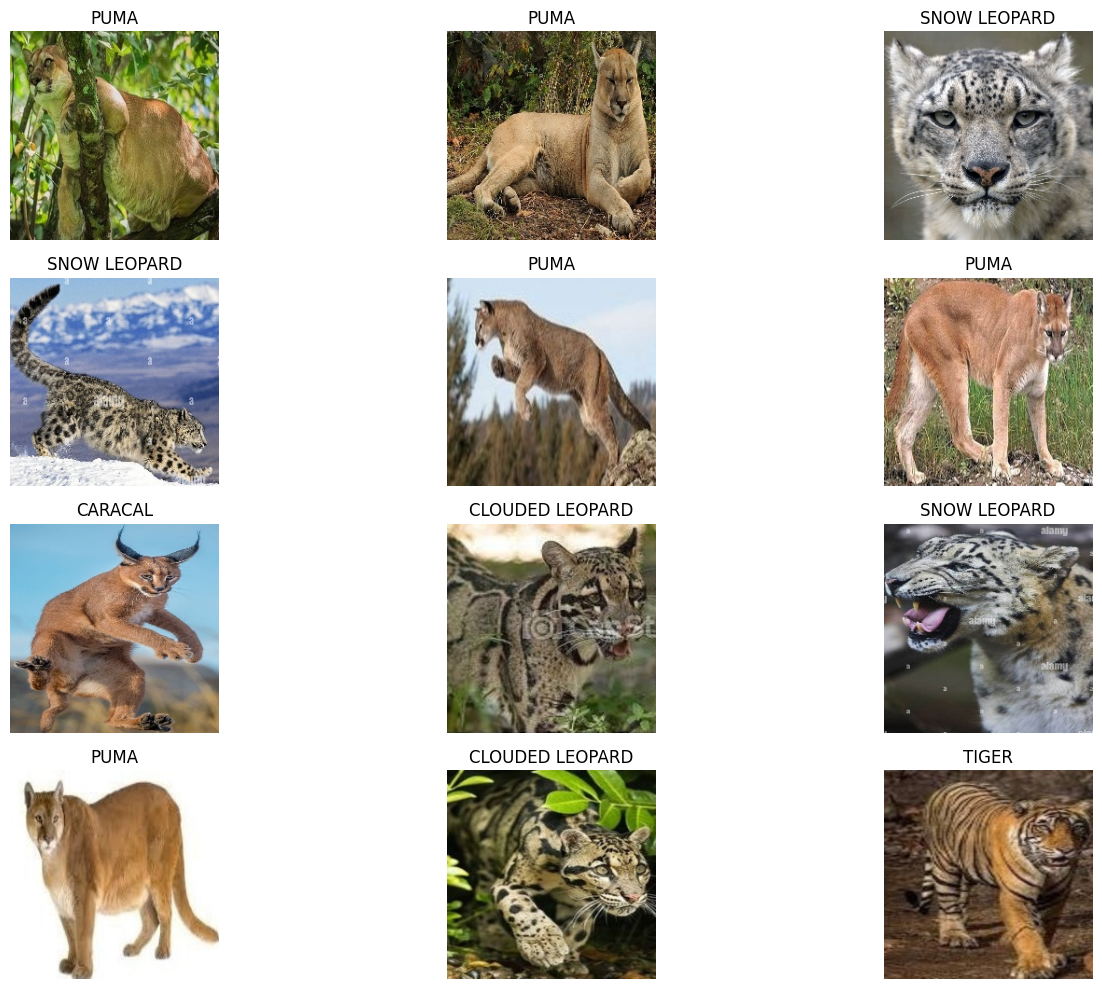

In [9]:
def load_random_images_from_directory(directory, num_images=12):
    images = []
    labels = []

    # List all subdirectories (classes)
    class_directories = [os.path.join(directory, d) for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

    # Randomly select images
    while len(images) < num_images:
        class_dir = random.choice(class_directories)
        class_name = os.path.basename(class_dir)
        image_file = random.choice(os.listdir(class_dir))
        image_path = os.path.join(class_dir, image_file)
        images.append(image_path)
        labels.append(class_name)

    return images, labels

def display_images(images, labels, rows=4, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.ravel()

    for i in range(len(images)):
        img = Image.open(images[i])
        axes[i].imshow(img)
        axes[i].set_title(labels[i])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Path to your main dataset folder
main_folder_path = '/content/cats-in-the-wild-image-classification/train'

# Load random images and their labels
random_images, image_labels = load_random_images_from_directory(main_folder_path)

# Display the images
display_images(random_images, image_labels)

**We need to create a dictionary that maps all of the file names to the name of the folder they are in so that we know the label for each image. We can do so using the following code:**

In [10]:
# Defining the root directory of training set
ROOT_DIR = "/content/cats-in-the-wild-image-classification/train"
labels = {}

# Mapping images and their labels
for folder in os.listdir(ROOT_DIR):
    for file in os.listdir(os.path.join(ROOT_DIR, folder)):
        if file.endswith(".jpg"):
            full_name = os.path.join(ROOT_DIR, folder, file)
            labels[full_name] = folder

files = labels.keys()

# **Loading the Model**

In [11]:
# Here the smallest model is used you can try others by your self
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

dinov2_vits14.to(device)

transform_image = T.Compose([T.ToTensor(), T.Resize(244), T.CenterCrop(224), T.Normalize([0.5], [0.5])])

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 131MB/s]


**Here we will define two functions one for loading our images an another that computes embedding for each image and returns a list of embeddings for all images**

In [12]:
def load_image(img: str) -> torch.Tensor:
    """
    Load an image and return a tensor that can be used as an input to DINOv2.
    """
    img = Image.open(img)

    transformed_img = transform_image(img)[:3].unsqueeze(0)

    return transformed_img

def compute_embeddings(files: list) -> dict:
    """
    Create an index that contains all of the images in the specified list of files.
    """
    all_embeddings = {}

    with torch.no_grad():
      for i, file in enumerate(tqdm(files)):
        embeddings = dinov2_vits14(load_image(file).to(device))

        all_embeddings[file] = np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist()

    with open("all_embeddings.json", "w") as f:
        f.write(json.dumps(all_embeddings))

    return all_embeddings

In [13]:
# Computing embeddings for our images
embeddings = compute_embeddings(files)

  0%|          | 0/2339 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


**Finally we use a SVC to fit our image embedding and labels**

In [14]:
# Creating a SVC instance
clf = svm.SVC(gamma='scale')

y = [labels[file] for file in files]

print(len(embeddings.values()))

embedding_list = list(embeddings.values())

clf.fit(np.array(embedding_list).reshape(-1, 384), y)

2339


SVC()

Predicted class: OCELOT


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


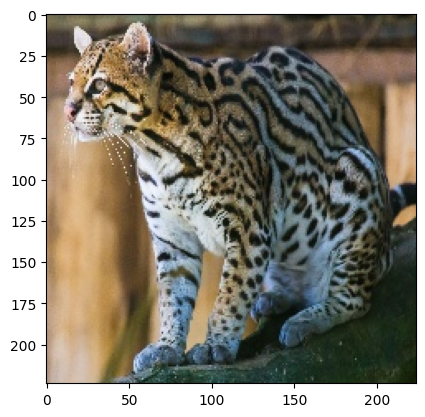

In [28]:
input_file = "/content/cats-in-the-wild-image-classification/test/OCELOT/1.jpg"
new_image = load_image(input_file)

with torch.no_grad():
    embedding = dinov2_vits14(new_image.to(device))

    prediction = clf.predict(np.array(embedding[0].cpu()).reshape(1, -1))

    print("Predicted class: " + prediction[0])
plt.imshow(cv2.cvtColor(cv2.imread(input_file),cv2.COLOR_BGR2RGB))

## **Testing the model on a few random sampled images**

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

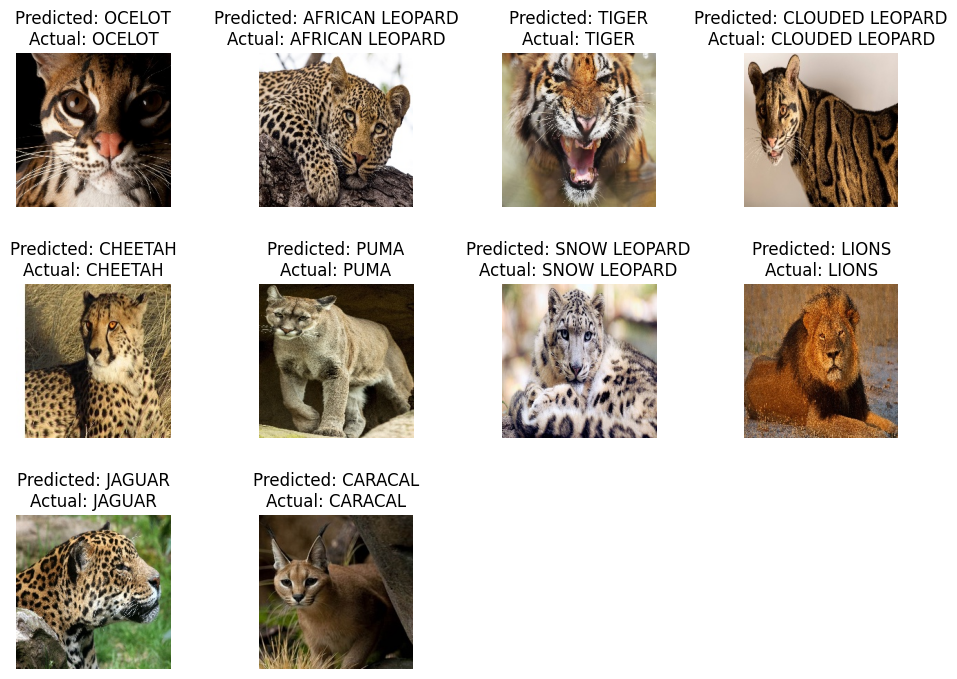

In [33]:
# Define the paths to your test dataset and the model
test_dataset_path = '/content/cats-in-the-wild-image-classification/test/'

# Create an empty 3x4 grid for displaying images
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)

# Initialize variables to track the number of selected images per class
selected_images_per_class = {class_folder: 0 for class_folder in os.listdir(test_dataset_path)}

# Loop to select random images (at least one from each class)
while sum(selected_images_per_class.values()) < 10:
    class_folder = random.choice(list(selected_images_per_class.keys()))
    class_path = os.path.join(test_dataset_path, class_folder)
    images_in_class = os.listdir(class_path)

    # Shuffle the images in the class and select the first one
    random.shuffle(images_in_class)
    image_name = images_in_class[0]
    image_path = os.path.join(class_path, image_name)

    # Check if we have already selected an image from this class
    if selected_images_per_class[class_folder] == 0:
        # Load and preprocess the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Predict using your SVC model
        # Replace this line with your actual prediction logic
        new_image = load_image(image_path)
        with torch.no_grad():
          embedding = dinov2_vits14(new_image.to(device))

          prediction = clf.predict(np.array(embedding[0].cpu()).reshape(1, -1))

        predicted_label = prediction[0]

        # Display the image with labels
        row_index = sum(selected_images_per_class.values()) // 4
        col_index = sum(selected_images_per_class.values()) % 4
        axes[row_index, col_index].imshow(image)
        axes[row_index, col_index].axis('off')
        axes[row_index, col_index].set_title(f"Predicted: {predicted_label}\nActual: {class_folder}")

        # Mark this class as selected
        selected_images_per_class[class_folder] += 1

# Hide empty subplots
for i in range(3):
    for j in range(4):
        if i * 4 + j >= sum(selected_images_per_class.values()):
            axes[i, j].axis('off')

# Show the grid of images
plt.show()